# 1. Preface

This project aims to develop and train a machine learning model based on a Convolutional Neural Network (CNN) to automatically detect and classify types of waste. The resulting model will be integrated into a waste-sorting machine to ensure waste is processed according to its category, thereby improving sorting efficiency and speed. The project uses accuracy as the evaluation metric, as precise classification is crucial. Misclassification could lead to waste being directed to incorrect processing streams, potentially increasing operational costs and reducing system efficiency. The model is targeted to achieve a minimum accuracy of 70% to support a more effective and environmentally friendly waste management system.

# 2. Import Libraries

In [ ]:
# Handling Data
import os
import glob
import random
import numpy as np
import pandas as pd
import zipfile

# Plotting Data
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Engineering
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

# Modelling
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.initializers import HeNormal, GlorotNormal

# Check TensorFlow version
print(tf.__version__)

import warnings
warnings.filterwarnings("ignore")

2.15.1


# 3. Data Loading

In this section, I will load the required data into a dataframe for further processing.

## 3.1. Download Dataset

The dataset used in this project is sourced from Kaggle, available at the following URL: https://www.kaggle.com/datasets/joebeachcapital/realwaste.

In [24]:
# # Source dataset : https://www.kaggle.com/datasets/joebeachcapital/realwaste
# !kaggle datasets download -d joebeachcapital/realwaste

<!-- Dataset yang didownload dari kaggle berupa compressed file sehingga perlu di unzip terlebih dahulu. -->

In [25]:
# # Unzip folder 
# with zipfile.ZipFile('realwaste.zip', 'r') as zip_ref:
#     zip_ref.extractall('dataset')

<!-- Folder yang sudah di unzip akan diubah directorynya untuk penyederhanaan path. -->

In [26]:
# # Move the folder
# # Define the source and destination paths
# source = 'dataset/realwaste-main/RealWaste'
# destination = 'RealWaste'

# # Move or rename the directory
# os.rename(source, destination)

In [27]:
# List all class in folders
labels = [f for f in os.listdir('RealWaste') if os.path.isdir(os.path.join('RealWaste', f))]
labels.sort()
labels

['Cardboard',
 'Food Organics',
 'Glass',
 'Metal',
 'Miscellaneous Trash',
 'Paper',
 'Plastic',
 'Textile Trash',
 'Vegetation']

The dataset contains 9 classes/targets.

## 3.2. Create Dataframe to Store Path of All Images

In this section, I will store the paths of all images into a dataframe.

In [28]:
# Define empty dictionary
all_files = {}

# Listing images of each category
for label in labels:
    file = glob.glob(f'RealWaste/{label}/*')
    file.sort()
    all_files[label] = file

# Convert the dictionary into a DataFrame
df = pd.DataFrame([(key, file) for key, files in all_files.items() for file in files], columns=['label', 'path'])

In [29]:
df

label                                    path
0      Cardboard     RealWaste/Cardboard/Cardboard_1.jpg
1      Cardboard    RealWaste/Cardboard/Cardboard_10.jpg
2      Cardboard   RealWaste/Cardboard/Cardboard_100.jpg
3      Cardboard   RealWaste/Cardboard/Cardboard_101.jpg
4      Cardboard   RealWaste/Cardboard/Cardboard_102.jpg
...          ...                                     ...
4747  Vegetation  RealWaste/Vegetation/Vegetation_95.jpg
4748  Vegetation  RealWaste/Vegetation/Vegetation_96.jpg
4749  Vegetation  RealWaste/Vegetation/Vegetation_97.jpg
4750  Vegetation  RealWaste/Vegetation/Vegetation_98.jpg
4751  Vegetation  RealWaste/Vegetation/Vegetation_99.jpg

[4752 rows x 2 columns]

In [30]:
# Check how many data in df
df.label.value_counts()

label
Plastic                921
Metal                  790
Paper                  500
Miscellaneous Trash    495
Cardboard              461
Vegetation             436
Glass                  420
Food Organics          411
Textile Trash          318
Name: count, dtype: int64

The dataset contains a total of 4752 entries across all classes. However, the class distribution is imbalanced. The `Plastic` and `Metal` classes have significantly higher values compared to other classes, while the `Textile Trash` class has far fewer entries than the others.

## 3.3. Drop Class

The number of classes/labels will be reduced to 6 to allow for more in-depth analysis. Therefore, the following targets will be removed:

- **`Miscellaneous Trash`**: This category includes waste that cannot be classified into other categories. Its inclusion could reduce the model's accuracy because its features and characteristics may vary significantly, leading to potential misclassification.  
- **`Vegetation`**: Vegetation waste such as leaves, grass, or plant remnants has physical characteristics that are vastly different from typical urban waste. Since the goal of this model is to classify waste for use in automated sorting machines, and vegetation waste is not commonly generated in urban areas, this category will be excluded.  
- **`Textile Trash`**: Textile waste, such as clothing or fabrics, has visual characteristics that differ greatly from other types of waste, especially in terms of texture and color. Additionally, textile waste can vary significantly in material types (e.g., cotton, wool, synthetic), making it challenging for the model to identify generalizable patterns.

In [31]:
df = df[~df['label'].isin(['Miscellaneous Trash', 'Textile Trash', 'Vegetation'])]

In [32]:
df.label.unique()

array(['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Paper', 'Plastic'],
      dtype=object)

The classes `Miscellaneous Trash`, `Vegetation`, and `Textile Trash` have been successfully removed from the dataset.

## 3.4. Data Balancing

In this section, I will perform data balancing due to the unequal distribution of data across classes. If this class imbalance is not addressed, it could lead to the model being biased toward the majority class. Therefore, I will balance the data. In this case, I have chosen to use undersampling for data balancing, as it is more efficient in terms of computational resources. Reducing the data size will speed up the model training time and reduce memory usage. By decreasing the number of samples from the majority class, the model will not only learn from a dominant class but also capture patterns from the minority class. Additionally, undersampling can help prevent overfitting, which could occur if the model is overly exposed to the majority class. While there is a risk of losing information from the majority class, this approach can provide better balance in model training and improve accuracy during testing.

In [33]:
# Extract the labels and the path (features)
X = df[['path']] 
y = df['label']

# Instantiate the RandomUnderSampler
rus = RandomUnderSampler(random_state=10)

# Apply the undersampling technique to balance the classes
X_resampled, y_resampled = rus.fit_resample(X, y)

# Combine the resampled data back into a DataFrame
df_bal = pd.DataFrame({
    'label': y_resampled,
    'path': X_resampled['path'], 
})

In [34]:
df_bal

label                                   path
181   Cardboard  RealWaste/Cardboard/Cardboard_262.jpg
274   Cardboard  RealWaste/Cardboard/Cardboard_346.jpg
98    Cardboard  RealWaste/Cardboard/Cardboard_188.jpg
147   Cardboard  RealWaste/Cardboard/Cardboard_231.jpg
260   Cardboard  RealWaste/Cardboard/Cardboard_333.jpg
...         ...                                    ...
3830    Plastic      RealWaste/Plastic/Plastic_778.jpg
3933    Plastic      RealWaste/Plastic/Plastic_870.jpg
3344    Plastic       RealWaste/Plastic/Plastic_34.jpg
3450    Plastic      RealWaste/Plastic/Plastic_435.jpg
3506    Plastic      RealWaste/Plastic/Plastic_486.jpg

[2466 rows x 2 columns]

# 4. Exploratory Data Analysis (EDA)

## 4.1. Check Class Distribution

In [72]:
# Check class distribution before balancing data
df.label.value_counts()

label
Plastic          921
Metal            790
Paper            500
Cardboard        461
Glass            420
Food Organics    411
Name: count, dtype: int64

In [35]:
# Check class distribution after balancing data
df_bal.label.value_counts()


label
Cardboard        411
Food Organics    411
Glass            411
Metal            411
Paper            411
Plastic          411
Name: count, dtype: int64

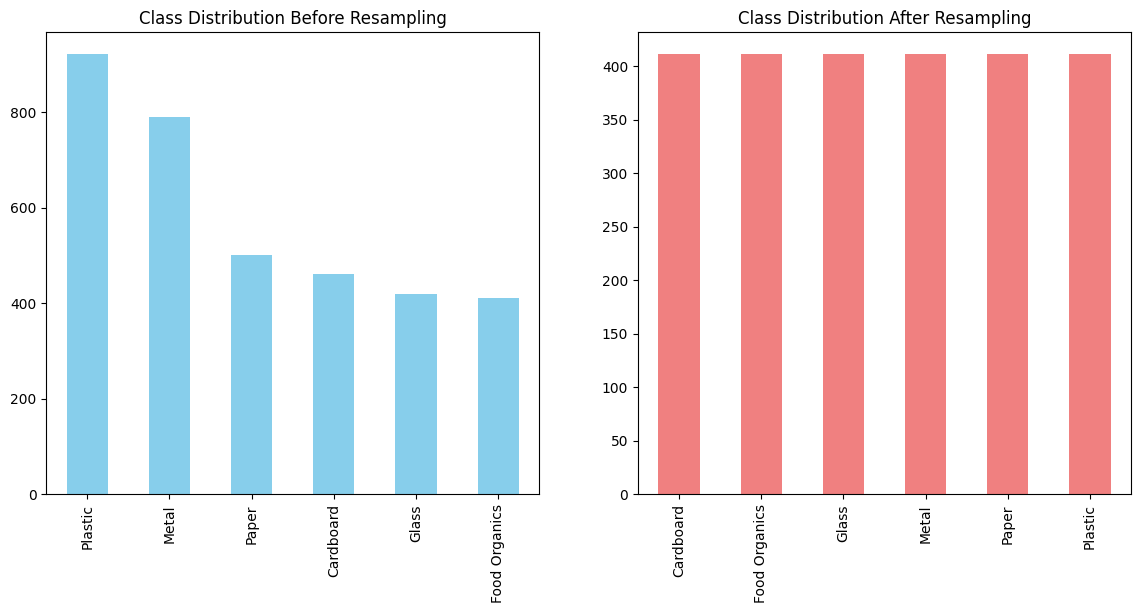

In [54]:
# Visualize the class distribution before and after balancing
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Before undersampling (original dataset)
df['label'].value_counts().plot(kind='bar', ax=ax[0], color='skyblue', title='Class Distribution Before Resampling')

# After undersampling (resampled dataset)
df_bal['label'].value_counts().plot(kind='bar', ax=ax[1], color='lightcoral', title='Class Distribution After Resampling')

ax[0].set_xlabel('')
ax[1].set_xlabel('')
plt.show()

There was a significant class imbalance in the dataset before balancing. The "Plastic" and "Metal" classes had 921 and 790 samples, respectively, which were much larger than other classes. This imbalance could lead to a trained model being biased toward the majority classes and struggling to classify minority classes. Therefore, data balancing is necessary to address this issue by reducing the number of samples in the majority classes. The primary goal is to make the class distribution more balanced so that the model can learn effectively from all classes. By applying a balancing technique, the resulting model is expected to achieve better accuracy across all classes, including the minority classes. After balancing, all classes now have 411 samples, matching the number of samples in the minority class.

## 4.2. Check Sample Image for Each Classes

Class: Cardboard


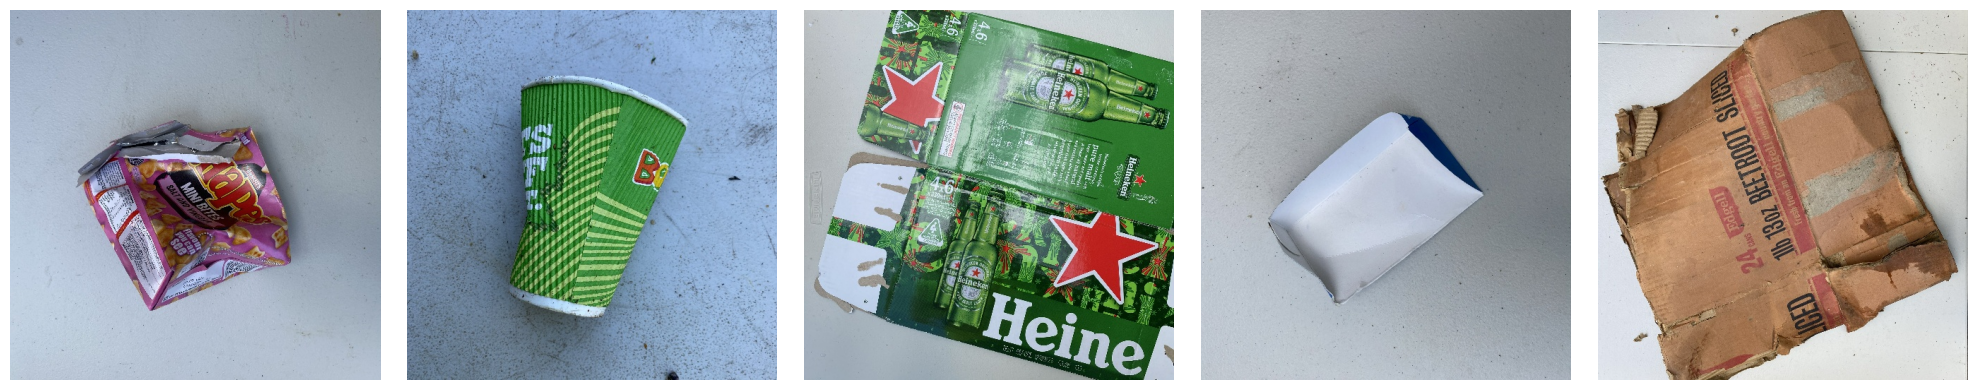

Class: Food Organics


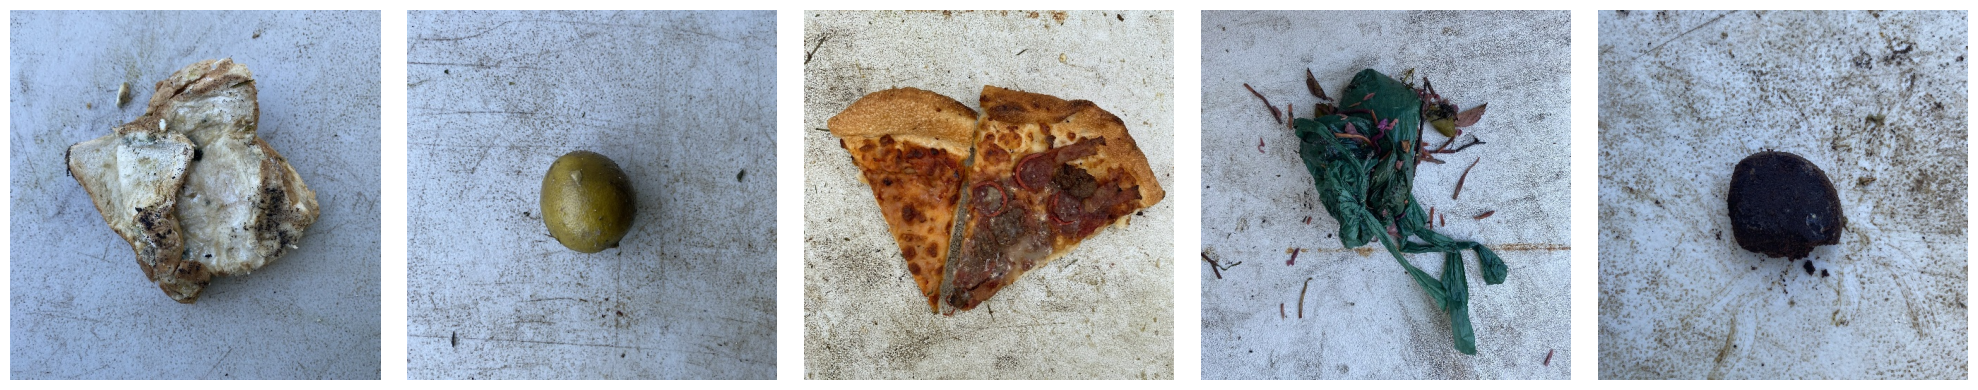

Class: Glass


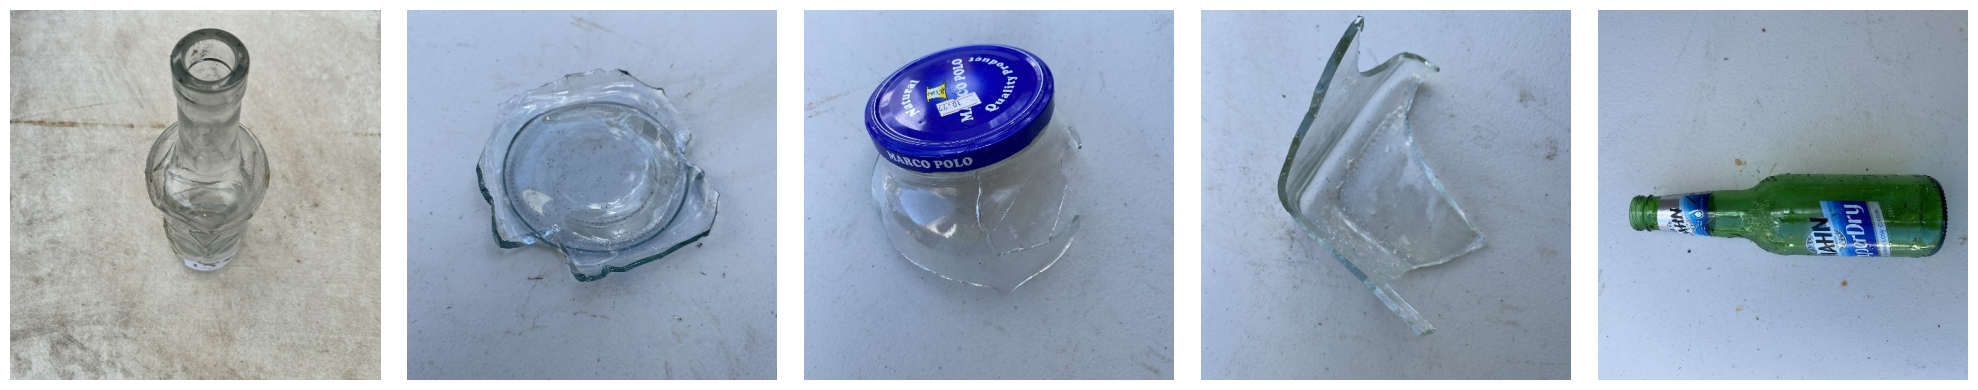

Class: Metal


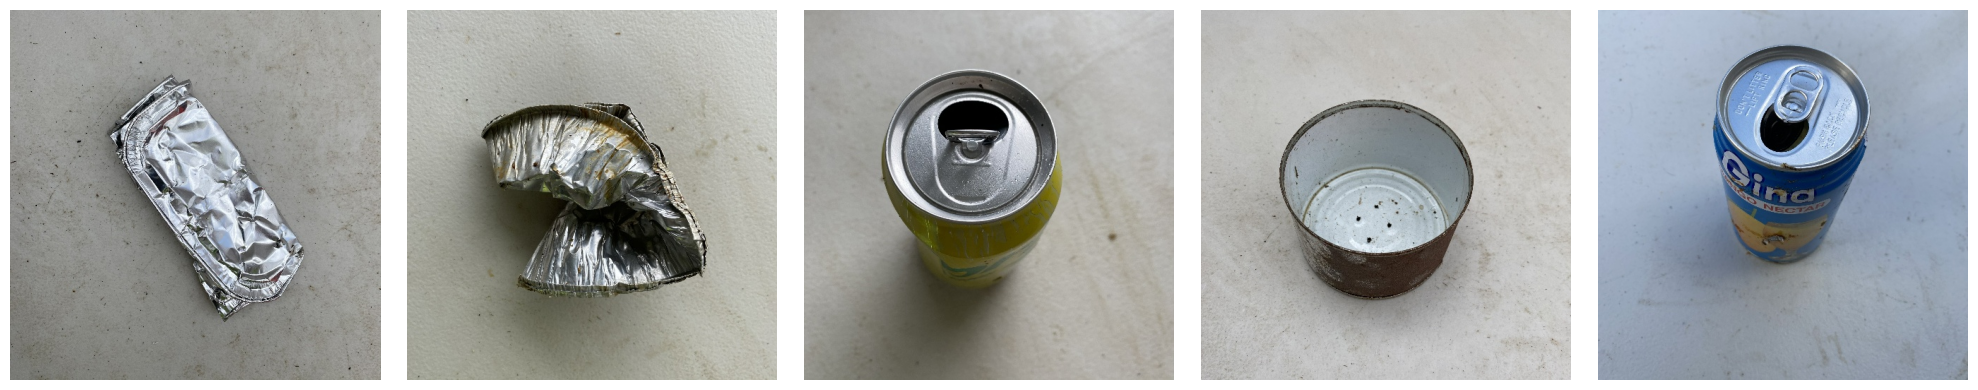

Class: Paper


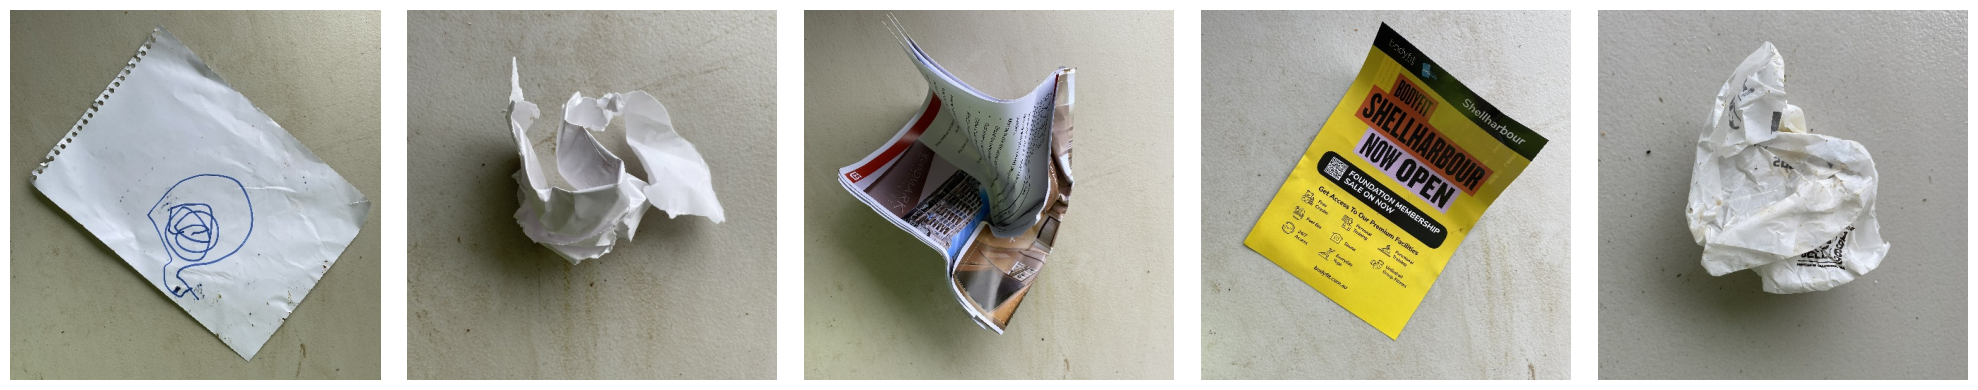

Class: Plastic


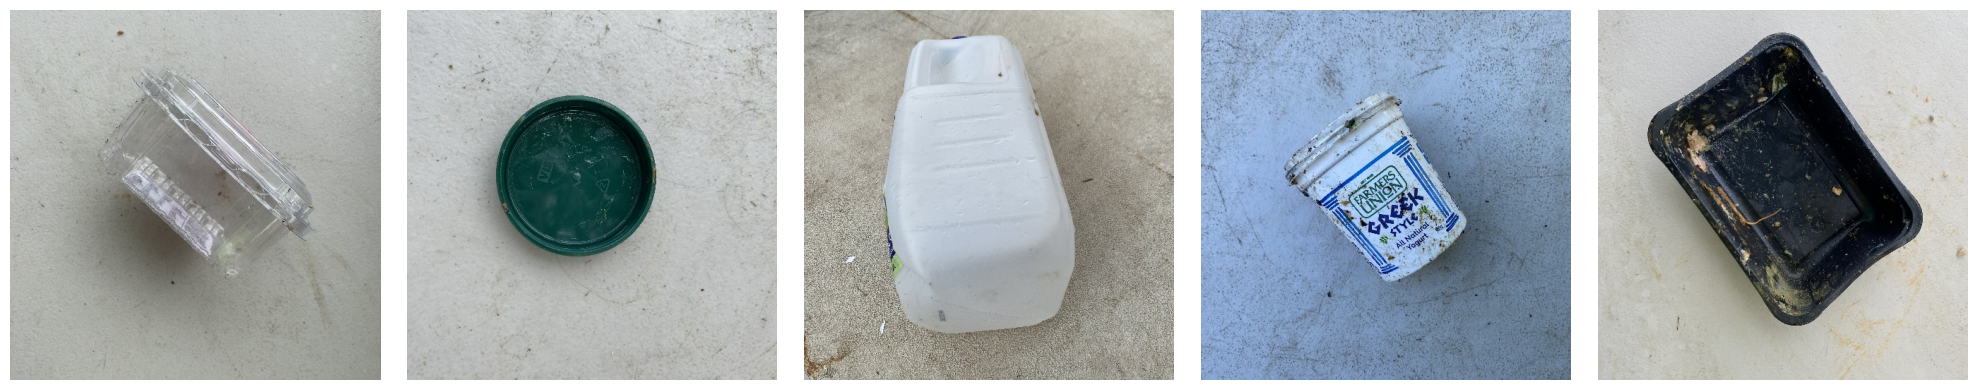

In [93]:
# Get unique labels
unique_labels = df_bal['label'].unique()

# Number of images per label to display
images_per_label = 5

# Iterate over each unique label
for label in unique_labels:
    print(f'Class: {label}')
    # Filter rows for the current label
    label_paths = df_bal[df_bal['label'] == label]['path'].tolist()

    # Randomly select 5 image paths from the current label
    selected_paths = random.sample(label_paths, images_per_label)

    # Create a new figure for the current label
    fig, axes = plt.subplots(nrows=1, ncols=images_per_label, figsize=(20, 4))
    
    # Loop through the selected images and plot them
    for i, path in enumerate(selected_paths):
        img = plt.imread(path)  # Read the image
        axes[i].imshow(img)  # Display the image
        axes[i].axis('off')  # Hide the axes

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

1. **Cardboard** has a distinctive corrugated texture often visible on the surface of thin cardboard, along with a natural brown or light gray color. Machines can utilize the repeating and regular wavy patterns present on the surface of cardboard, which serve as key visual features for identification.

2. **Food Organics** tend to have irregular shapes and textures, as they consist of crushed or wet food remnants. Their texture can be soft or clumpy, often displaying natural colors such as red, green, yellow, or brown, depending on the food type. Machines can recognize organic waste through irregular texture variations and moisture, which influence how light is reflected.

3. **Glass** has a smooth and shiny surface, with colors ranging from transparent to tinted hues like green, blue, or brown. Glass typically sparkles or reflects light from its surface. Models can distinguish glass by detecting its glossy appearance compared to the more opaque surfaces of materials like plastic or metal.

4. **Metal** features smooth, shiny, or rusty surfaces. Its shape can be highly structured, such as cans or metal sheets, with colors ranging from metallic gray to silver or black if rusted. Metal can be identified by its reflective surface or sheen and the consistent geometric patterns seen in items like cans or sheets.

5. **Paper** often has a smooth or slightly rough texture, with colors varying from white, brown, and gray to other hues. It can appear as flat sheets, rolls, or torn pieces and typically lacks the glossiness of plastic or metal. Paper tends to have a more uniform surface texture and is thinner compared to cardboard, which aids in differentiation.

6. **Plastic** has a surface that is frequently smooth and shiny, with a wide range of colors from transparent to vivid shades like red, blue, or green. Plastics can appear as bags, bottles, or wrappers, often with unique shapes and flexibility. Plastic is recognizable by its characteristic surface gloss and vibrant colors or transparency, which are hallmarks of this material.

# 5. Feature Engineering

## 5.1. Split Train-set and Test-set

In this section, I will split the dataset into a training set and a test set. The training set will be used to train the model and serve as validation data during the training process, where the model will be evaluated at each epoch to monitor its performance. Once the training is complete and the best model is obtained, the model will be tested using the test set. This testing phase aims to assess the model's ability to classify unseen data, providing an accurate evaluation of the model's performance.

In [38]:
train, test = train_test_split(df_bal, test_size=0.15, random_state=10, stratify=df_bal['label'])

## 5.2. Data Augmentation

In this section, I will perform data augmentation to increase the variation in the dataset and help the model better understand images without memorizing specific patterns. By applying this technique, the model can learn from various perspectives and conditions, enhancing its ability to generalize when faced with new data. Additionally, data augmentation can help address the issue of overfitting, where the model is overly trained on the training data and performs poorly on unseen data. This process contributes to improving the model's accuracy and robustness in waste image classification.

As explained earlier, the data will be divided into training, validation, and test sets to ensure the model is trained with sufficient data, tested on unseen data, and objectively evaluated. This is essential to ensure a high-performing model capable of classifying waste with high accuracy and good generalization on unseen data.

The parameters used are as follows:
- **`img_height` = 220** and **`img_width` = 220**: Specifies the input image size for processing, which affects model performance and efficiency.  
- **`batch_size` = 32**: Sets the number of images processed in each iteration, influencing training speed and memory usage.  

Images will be resized to the specified `img_height` and `img_width`, with `class_mode` set to `sparse` for multiclass classification. In the training and validation sets, the data will be shuffled (`shuffle=True`) to prevent the model from memorizing the order of the images, fostering better generalization. In contrast, for the test set, images will not be shuffled (`shuffle=False`) since it is used for evaluation. The `seed` parameter ensures reproducibility of the results.

In [39]:
# Define random_state
seed = 10

# Define hyperparameters
img_height= 220
img_width= 220
batch_size= 32

In [40]:
# Create batch generator for train-set, val-set, and test-set

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.,
                                                                horizontal_flip=True,
                                                                rotation_range=180,
                                                                zoom_range=0.05,
                                                                validation_split=0.20)

train_set = train_datagen.flow_from_dataframe(train,
                                              x_col='path',
                                              y_col='label',
                                              target_size=(img_height,img_width),
                                              class_mode='sparse',
                                              subset='training',
                                              batch_size=batch_size,
                                              shuffle=True,
                                              seed=seed)

val_set = train_datagen.flow_from_dataframe(train,                                              
                                            x_col='path',
                                            y_col='label',
                                            target_size=(img_height,img_width),
                                            class_mode='sparse',
                                            subset='validation',
                                            batch_size=batch_size,
                                            shuffle=True,
                                            seed=seed)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

test_set = test_datagen.flow_from_dataframe(test,                                            
                                            x_col='path',
                                            y_col='label',
                                            target_size=(img_height,img_width),
                                            class_mode='sparse',
                                            batch_size=batch_size,
                                            shuffle=False,
                                            seed=seed)

Found 1677 validated image filenames belonging to 6 classes.
Found 419 validated image filenames belonging to 6 classes.
Found 370 validated image filenames belonging to 6 classes.


Here are the encoded class labels.

In [41]:
# Show labels
train_set.class_indices

{'Cardboard': 0,
 'Food Organics': 1,
 'Glass': 2,
 'Metal': 3,
 'Paper': 4,
 'Plastic': 5}

# 6. ANN Training (Sequential API/Functional API)

## 6.1. Model Definition

**Defining the Model Using ANN**  

In this section, I will define the model using an Artificial Neural Network (ANN). The architecture of the ANN will utilize the Sequential API because it is well-suited for linear and relatively simple structures. Using the Sequential model makes the code easier to understand and allows the model to be built and configured without additional components like layer merging or branching. This approach is ideal for simple image classification tasks.

The base model will implement a simple Convolutional Neural Network (CNN) architecture consisting of the following layers:  

1. **Conv2D**  
   - Uses 2 filters with a kernel size of (3, 3). The small filter size is chosen to maintain model complexity at a low level. Padding is set to 'valid' to generate a smaller output while capturing features effectively. The 'ReLU' activation function is used to prevent vanishing gradients, as it is considered one of the best activation functions for CNNs.  

2. **MaxPooling2D**  
   - Pool size of (2, 2) is applied to further reduce image dimensions while preserving important features.  

3. **Flatten**  
   - Converts a 3D matrix (height, width, channels) into a 1D vector for processing in Dense layers.  

4. **Dense**  
   - Contains 6 neurons corresponding to the number of output classes.  
   - 'Softmax' activation function is applied to produce probabilities for each class, with the highest probability indicating the predicted class.  
   - 'GlorotNormal' initializer is selected to accelerate convergence, which is a best practice when using softmax activation.  

**Model Compilation**:  
- **Loss function**: `sparse_categorical_crossentropy`, as the targets are multiclass and not one-hot encoded (values: 0, 1, 2, 3, 4, 5).  
- **Optimizer**: 'Adam', chosen for its efficiency in reaching convergence quickly.  
- **Evaluation metric**: 'Accuracy', as the primary goal is precise classification of waste types. Misclassification could lead to incorrect waste processing paths, increasing costs and reducing the efficiency of waste-sorting machines.

In [198]:
# Clear session
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# Define model
model = Sequential()
model.add(Conv2D(2, (3,3), padding='valid',activation='relu',strides=(2, 2), input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(6, activation='softmax', kernel_initializer=GlorotNormal(seed)))

# Compile
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 109, 109, 2)       56        
                                                                 
 max_pooling2d (MaxPooling2  (None, 54, 54, 2)         0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 5832)              0         
                                                                 
 dense (Dense)               (None, 6)                 34998     
                                                                 
Total params: 35054 (136.93 KB)
Trainable params: 35054 (136.93 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# # Plot layers
# tf.keras.utils.plot_model(model, show_shapes=True)

## 6.2. Model Training

In this section, I will train the model by setting the number of epochs to 30 and the batch size to 32.

In [199]:
# Train the model
history = model.fit(train_set, 
                    epochs=30, 
                    validation_data=val_set, 
                    batch_size=batch_size)

Epoch 1/30
53/53 [==============================] - 20s 369ms/step - loss: 1.7151 - accuracy: 0.2618 - val_loss: 1.6327 - val_accuracy: 0.3126
Epoch 2/30
53/53 [==============================] - 19s 355ms/step - loss: 1.6263 - accuracy: 0.3304 - val_loss: 1.5937 - val_accuracy: 0.3294
Epoch 3/30
53/53 [==============================] - 19s 353ms/step - loss: 1.5815 - accuracy: 0.3631 - val_loss: 1.5385 - val_accuracy: 0.4010
Epoch 4/30
53/53 [==============================] - 19s 362ms/step - loss: 1.5492 - accuracy: 0.3912 - val_loss: 1.5375 - val_accuracy: 0.3747
Epoch 5/30
53/53 [==============================] - 19s 359ms/step - loss: 1.5676 - accuracy: 0.3876 - val_loss: 1.5099 - val_accuracy: 0.3866
Epoch 6/30
53/53 [==============================] - 19s 361ms/step - loss: 1.5125 - accuracy: 0.4007 - val_loss: 1.4534 - val_accuracy: 0.4296
Epoch 7/30
53/53 [==============================] - 19s 354ms/step - loss: 1.4795 - accuracy: 0.4120 - val_loss: 1.4505 - val_accuracy: 0.4558

## 6.3. Model Evaluation

In this section, I will evaluate the trained model. The model will be evaluated based on the accuracy metric for the train, validation, and test data.

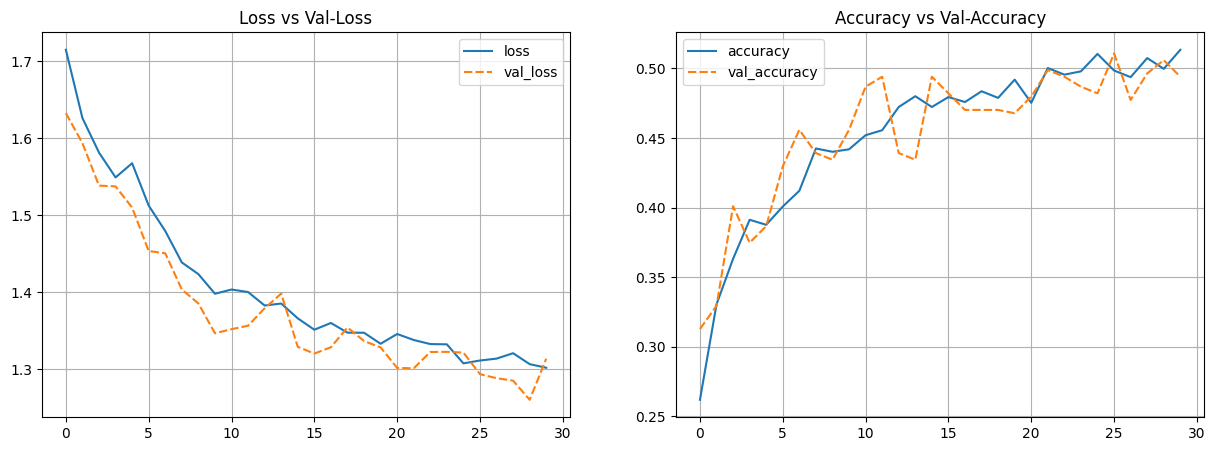

In [200]:
# Plot training results

history_df = pd.DataFrame(history.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

Based on the graph above, the loss and validation loss decrease as the epochs increase, indicating that the model is consistently learning and improving its predictions during training. The decreasing loss on both the training data (train loss) and validation data (val-loss) is an indicator that the model is successfully reducing errors in predicting the classes for both the trained data and unseen validation data. This suggests that the model is not suffering from overfitting. Therefore, it can be concluded that the model is undergoing an effective learning process at each epoch.

From the accuracy graph between train and validation in the last epoch, the difference is only 2%, indicating that the model is not overfitting. This means the model generalizes well and is not merely memorizing the training data. However, the overall accuracy obtained is around 50%, which suggests there is still room for improvement for the model to achieve a higher accuracy. The model has low accuracy due to its simple architecture, which uses only 1 convolutional layer and lacks hidden layers before reaching the output. This architecture is too simple to capture the more complex patterns in this multiclass image classification problem for waste sorting.

In [216]:
# Check the performance of test-set

## Get the probability
y_pred_prob = model.predict(test_set)

## Get class with maximum probability
y_pred_class = np.argmax(y_pred_prob, axis=-1)

## Display Classification Report
print(classification_report(test_set.classes, y_pred_class, target_names=np.array(list(train_set.class_indices.keys()))))

12/12 [==============================] - 1s 67ms/step
               precision    recall  f1-score   support

    Cardboard       0.41      0.45      0.43        62
Food Organics       0.50      0.90      0.64        62
        Glass       0.58      0.46      0.51        61
        Metal       0.51      0.29      0.37        62
        Paper       0.58      0.55      0.56        62
      Plastic       0.33      0.25      0.28        61

     accuracy                           0.48       370
    macro avg       0.48      0.48      0.47       370
 weighted avg       0.48      0.48      0.47       370



When the model was used to predict the test data, it showed an accuracy similar to the training and validation data, around 48%. Looking at the F1-Score for each class, the model struggled to classify `cardboard`, `metal`, and `plastic`. This may occur because some images in these classes lack distinct or consistent characteristics. Some images within each class may have high variability, such as differences in shape, texture, or image conditions, which makes it difficult for the model to identify clear and consistent patterns. This can happen if the images in these classes do not have dominant or uniform features, thus complicating the model's ability to differentiate between one category and another. This variability makes the model more prone to misclassification errors.

# 7. ANN Improvement (Sequential API/Functional API)

## 7.1. Model Definition

In this improvement section, I will continue using the Sequential API due to its simplicity and suitability for models with linear architectures. However, I will add several convolutional layers and hidden layers to increase the model's complexity, enabling it to capture more complex and deeper patterns. With the addition of these layers, the model's accuracy is expected to improve.

If the model starts to overfit, I will generalize it by adding dropout to prevent any neuron from becoming too dominant. Dropout will randomly deactivate some neurons during training, ensuring that the model does not rely on information from a single neuron and helps prevent overfitting. Additionally, I will use a regularizer to penalize large weights, encouraging the model to choose smaller, more stable weights. This will assist the model in becoming more general in understanding the data.

For the loss function, optimizer, and metrics, I will use the same configuration as the base model, which includes sparse categorical crossentropy as the loss function, Adam as the optimizer, and accuracy as the evaluation metric. This approach is expected to maintain stability and faster convergence while enhancing the model's ability to classify waste more accurately.

**CNN Model Architecture** <br>
**Conv2D**: This convolutional layer is used to extract features from images. There are several convolutional layers, with an increasing number of filters (16, 32, 64) in each layer. Each of these layers uses a 3x3 kernel size and the ELU (Exponential Linear Unit) activation function, which helps the model learn faster and address the vanishing gradient problem. <br>
**MaxPooling2D**: A pooling layer used to reduce the dimensionality of the output from each convolutional layer with a 2x2 pooling size. This helps to reduce computation and prevent overfitting. <br>
**Flatten**: Converts the output of the convolutional and pooling layers into a one-dimensional vector that is then passed to the Dense layer. <br>
**Dense**: Hidden layers consisting of two layers with 1024 and 512 neurons, using ELU activation to introduce non-linearity. These layers connect the features extracted by the convolutional layers and generate predictions. <br>
**Dropout**: Used to reduce overfitting by randomly deactivating some neurons during training to reduce the model’s reliance on specific features. <br>
**Output Layer**: The output layer uses the 'softmax' activation function to generate probabilities for each of the 6 classes, as this is a multiclass classification problem.

**Model Compilation** <br>
**Loss Function**: The model uses 'sparse categorical crossentropy' as the loss function due to the multiclass classification problem, where the target labels are integers (not one-hot encoded). <br>
**Optimizer**: Adam is chosen as the optimizer because of its ability to adapt to the learning rate and accelerate convergence. <br>
**Metrics**: Accuracy is used as the metric to evaluate the performance of the model.

**Callbacks** <br>
**ReduceLROnPlateau**: This callback is used to automatically decrease the learning rate if the val_loss does not show improvement after a certain number of epochs. It helps the model learn more slowly and carefully once a certain point is reached. <br>
**EarlyStopping**: This callback helps prevent overfitting by stopping the training if the val_loss does not improve after a specified number of epochs. This prevents wasting training time.

In [206]:
# Clear session
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# Define model
model_imp = Sequential()
model_imp.add(Conv2D(16, (3,3), padding='same',activation='elu',strides=(1, 1), input_shape=(img_height, img_width, 3)))
model_imp.add(MaxPooling2D(2, 2))
model_imp.add(Conv2D(16, (3,3), padding='same',activation='elu'))
model_imp.add(MaxPooling2D(2, 2))
model_imp.add(Conv2D(32, (3,3),padding='same',activation='elu',))
model_imp.add(MaxPooling2D(2, 2))
model_imp.add(Conv2D(32, (3,3),padding='same',activation='elu',))
model_imp.add(MaxPooling2D(2, 2))
model_imp.add(Conv2D(64, (3,3),padding='same',activation='elu',))
model_imp.add(MaxPooling2D(2, 2))
model_imp.add(Conv2D(64, (3,3),padding='same',activation='elu',))
model_imp.add(MaxPooling2D(2, 2))
model_imp.add(Flatten())
model_imp.add(Dense(1024, activation='elu', kernel_initializer=HeNormal(seed)))
model_imp.add(Dense(512, activation='elu', kernel_initializer=HeNormal(seed)))
model_imp.add(Dropout(0.3))
model_imp.add(Dense(6, activation='softmax', kernel_initializer=GlorotNormal(seed)))

# Compile
model_imp.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_imp.summary()

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.5,          # Reduce learning rate by half
    patience=3,          # Number of epochs with no improvement before reducing the LR
    min_lr=1e-6,         # Minimum learning rate
    verbose=1            # Print logs when reducing learning rate
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=0,
    restore_best_weights=True,
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 55, 55, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 55, 55, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 27, 27, 32)        0

## 7.2. Model Training

In this section, I will train the model by setting the number of epochs to 30 and the batch size to 32.

In [207]:
# Train the model
history_imp = model_imp.fit(
    train_set,        # Training data
    epochs=30,         # Number of epochs
    batch_size=batch_size,     # Batch size
    validation_data=val_set,  # Validation data
    callbacks=[reduce_lr, early_stop]  # List of callbacks to use
)

Epoch 1/30
53/53 [==============================] - 28s 510ms/step - loss: 1.6614 - accuracy: 0.3214 - val_loss: 1.4611 - val_accuracy: 0.4105 - lr: 0.0010
Epoch 2/30
53/53 [==============================] - 14s 260ms/step - loss: 1.3186 - accuracy: 0.4770 - val_loss: 1.2028 - val_accuracy: 0.5561 - lr: 0.0010
Epoch 3/30
53/53 [==============================] - 14s 252ms/step - loss: 1.2647 - accuracy: 0.5146 - val_loss: 1.2322 - val_accuracy: 0.5179 - lr: 0.0010
Epoch 4/30
53/53 [==============================] - 13s 250ms/step - loss: 1.1660 - accuracy: 0.5414 - val_loss: 1.1588 - val_accuracy: 0.5012 - lr: 0.0010
Epoch 5/30
53/53 [==============================] - 14s 257ms/step - loss: 1.1319 - accuracy: 0.5677 - val_loss: 1.0524 - val_accuracy: 0.6181 - lr: 0.0010
Epoch 6/30
53/53 [==============================] - 14s 259ms/step - loss: 1.0544 - accuracy: 0.6052 - val_loss: 1.0282 - val_accuracy: 0.6181 - lr: 0.0010
Epoch 7/30
53/53 [==============================] - 13s 252ms/st

## 7.3. Model Evaluation

In this section, I will evaluate the trained model. The model will be evaluated based on the accuracy metric for the train, validation, and test datasets.

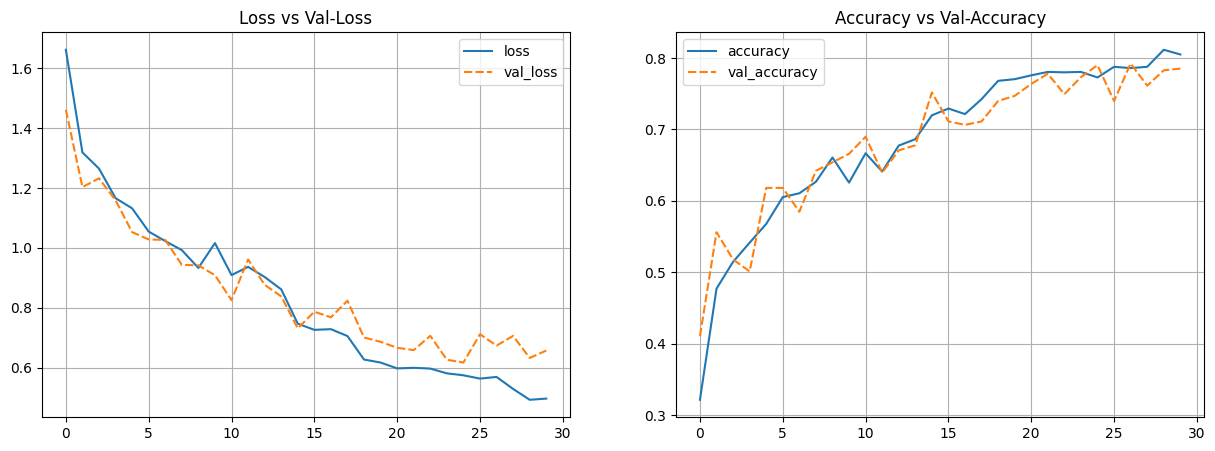

In [208]:
# Plot training results

history_df_imp = pd.DataFrame(history_imp.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_df_imp[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_df_imp[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

Based on the graph above, the loss and val-loss values decrease as the epochs increase, indicating that the model is consistently learning and improving its predictions during training. The decreasing train loss and val-loss are indicators that the model successfully reduced errors in predicting classes for both the training data and the unseen validation data. This suggests that the model underwent an effective learning process in each epoch. Additionally, when comparing the loss graph between the base model and the improved model, there is a more significant decrease in loss in the improved model. This decrease indicates that the improved model performs better, with a lower loss, meaning it can minimize errors more efficiently.

From the accuracy graph between the train and validation data, the difference at the last epoch is only 2.2%. This small difference suggests that the model is not overfitting, which often happens when a model "memorizes" the training data and fails to generalize well to unseen data. In this case, the model shows good generalization ability, meaning it can make accurate predictions not only on the training data but also on new, unseen data. As a result, this model can be expected to perform well on the test data.

In [214]:
# Check the performance of test-set

## Get the probability
y_pred_prob = model_imp.predict(test_set)

## Get class with maximum probability
y_pred_class = np.argmax(y_pred_prob, axis=-1)

## Display Classification Report
print(classification_report(test_set.classes, y_pred_class, target_names=np.array(list(train_set.class_indices.keys()))))

12/12 [==============================] - 1s 74ms/step
               precision    recall  f1-score   support

    Cardboard       0.64      0.76      0.70        62
Food Organics       0.83      0.94      0.88        62
        Glass       0.84      0.75      0.79        61
        Metal       0.63      0.65      0.64        62
        Paper       0.88      0.61      0.72        62
      Plastic       0.50      0.54      0.52        61

     accuracy                           0.71       370
    macro avg       0.72      0.71      0.71       370
 weighted avg       0.72      0.71      0.71       370



When the model was used to predict the test data, the results showed an accuracy of 71%, which is slightly lower than the accuracy obtained from the validation data. This difference indicates that, while the model has learned well from the training and validation data, challenges arise when applied to more variable or unseen data.

Upon deeper analysis of the F1-Score for each class, the model still faces difficulties in classifying certain categories like `cardboard`, `metal`, and `plastic`, each of which has a relatively low F1-score. This suggests that, while the model can recognize some classes well, it struggles to differentiate between certain classes that may have visual similarities or characteristics that are harder for the model to identify.

Nevertheless, the model obtained is an improvement over the previous one, as evidenced by the increased accuracy from 48% to 71%. Moreover, the target of 70% has been achieved, meaning the model has met the set expectations.

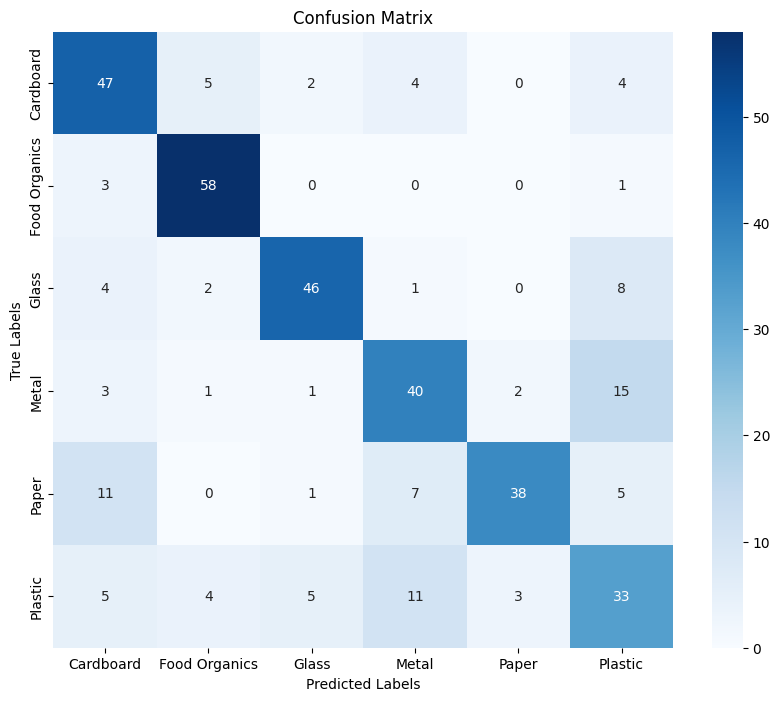

In [215]:
# Confusion Matrix
conf_matrix = confusion_matrix(test_set.classes, y_pred_class)

# Visualize the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=df_bal['label'].unique(), yticklabels=df_bal['label'].unique())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

The confusion matrix shows that the model performs well in classifying Food Organic and Glass. However, the model struggles to differentiate between metal and plastic, as it often misclassifies metal as plastic. Additionally, paper is frequently misclassified as cardboard and metal, while plastic is often misclassified as metal. This may be due to some classes sharing similar characteristics, making it challenging for the model to distinguish between them accurately. The overlapping features or visual similarities between these categories could be causing the misclassifications.

# 8. Model Saving

In [218]:
# # Saving file
model_imp.save('model_improvement.h5')

/opt/anaconda3/envs/phase2/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# 9. Conclusion

The process of building a model to classify waste was done using the Sequential API architecture due to its simplicity and ease of interpretation. The model is evaluated using the 'accuracy' metric because it is essential for the model to classify images correctly, ensuring that waste is processed according to its type. Any misclassification can lead to waste entering the wrong processing path, increasing costs and reducing the efficiency of the waste sorting machine.

The model was developed with both a base model and an improved model. In the base model, the architecture used only one convolutional layer, which resulted in a model that was too simple and unable to capture complex patterns, yielding an accuracy of 48%. After improvements by adding more complexity to the model, such as adding additional convolutional layers, hidden layers, dropout, and changing the activation function to ELU, the resulting model achieved a better accuracy of 71%.

The strength of the resulting model is its ability to distinguish several classes like food organics and glass, which have clear visual characteristics, showing good performance in terms of precision and recall for these classes. However, the weakness of the model lies in its difficulty distinguishing between classes like cardboard, metal, and plastic, which have similarities in texture and color, leading to frequent misclassifications for these categories.

For further improvement, techniques such as transfer learning with a more complex pre-trained model or fine-tuning hyperparameters could be explored to achieve better performance.